## Installation

In [2]:
# !git clone https://github.com/AI4Finance-Foundation/FinRL-Meta.git

Cloning into 'FinRL-Meta'...
remote: Enumerating objects: 7978, done.
remote: Counting objects: 100% (217/217), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 7978 (delta 104), reused 177 (delta 77), pack-reused 7761
Receiving objects: 100% (7978/7978), 170.71 MiB | 19.27 MiB/s, done.
Resolving deltas: 100% (4619/4619), done.
Updating files: 100% (423/423), done.


In [4]:
# %%capture
# !pip install stable-baselines3[extra]
# !pip install exchange-calendars
# !pip install stockstats
# !pip install pyfolio
# !pip install pyportfolioopt
# !pip install mplfinance
# !pip install gymnasium
# !pip install pandas
# !pip install matplotlib
# !pip install opencv-python
# !pip install gym
# !pip install yfinance
# !conda install -c conda-forge ta-lib

In [1]:
import os

os.chdir("/home/ubuntu/algorithmic_trading/CNN-DRL/FinRL-Meta")

## Imports

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gymnasium as gym
from numpy import random as rd
import mplfinance as mpf
# import cv2
from datetime import datetime, timedelta
import exchange_calendars as xcals

import sys
sys.path.append("/home/ubuntu/algorithmic_trading/CNN-DRL")

from meta import config, config_tickers
from meta.data_processor import DataProcessor
from stable_baselines3.common.vec_env import DummyVecEnv
from agents2.agent import DRLAgent
from envs.StockTradingEnvCNN import StockTradingEnvCNN
from envs.StockTradingEnvMLP import StockTradingEnvMLP
from policies.CnnPolicy import CustomCNN, CustomCNN2
from plot2 import get_baseline

/home/ubuntu/anaconda3/envs/py39/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


## Hyperparameters

In [3]:
TRAIN_START_DATE = config.TRAIN_START_DATE
TRAIN_END_DATE = config.TRAIN_END_DATE
TEST_START_DATE = config.TEST_START_DATE
TEST_END_DATE = config.TEST_END_DATE
DOW_30_TICKER = config_tickers.DOW_30_TICKER
INDICATORS = config.INDICATORS

In [4]:
# total_timesteps: the number of steps in total the agent will do for any environment
# n_updates = total_timesteps // self.n_batch
# n_batch = n_steps * n_envs
A2C_PARAMS = {"n_steps": 10, "ent_coef": 0.005, "learning_rate": 0.0004}
SAC_PARAMS = {"batch_size": 128,"buffer_size": 100000,"learning_rate": 0.0001,"learning_starts": 100,"ent_coef": "auto_0.1",}
PPO_PARAMS = {"n_steps": 2048,"ent_coef": 0.01,"learning_rate": 0.00025,"batch_size": 128}
TD3_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}

In [5]:
policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=30),
)

policy_candle_kwargs = dict(
    features_extractor_class=CustomCNN2,
    features_extractor_kwargs=dict(features_dim=1),
)

In [6]:
cwd = "/home/ubuntu/algorithmic_trading/CNN-DRL"

## Environment

In [7]:
from __future__ import annotations

from typing import List

import os
import cv2
import mplfinance as mpf
import glob
import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gymnasium import spaces
from gymnasium.utils import seeding
from stable_baselines3.common.vec_env import DummyVecEnv

matplotlib.use("Agg")

# from stable_baselines3.common.logger import Logger, KVWriter, CSVOutputFormat


class StockTradingEnvCandle(gym.Env):
    """A stock trading environment for OpenAI gym"""

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df: pd.DataFrame,
        stock_dim: int,
        hmax: int,
        initial_amount: int,
        num_stock_shares: list[int],
        buy_cost_pct: list[float],
        sell_cost_pct: list[float],
        reward_scaling: float,
        state_space: int,
        action_space: int,
        tech_indicator_list: list[str],
        turbulence_threshold=None,
        risk_indicator_col="turbulence",
        make_plots: bool = False,
        print_verbosity=10,
        time_index=0,
        period=28,
        height=299,
        width=299,
        channel=3,
        initial=True,
        previous_info=[],
        model_name="",
        mode="",
        iteration="",
        data_dir=""
    ):        
        self.time_index = time_index
        self.period = period
        self.df = df
        self.data_dir = data_dir
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.num_stock_shares = num_stock_shares
        self.initial_amount = initial_amount  # get the initial cash
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.height = height
        self.width = width
        self.channel = channel
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_space,))
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.channel, self.height, self.width)
        )
        self.df.time = pd.to_datetime(self.df.time)
        self.sorted_times = sorted(set(self.df.time))
        day = self.sorted_times[self.time_index]
        self.data = self.df[self.df["time"] == day]
        self.terminal = False
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        self.turbulence_threshold = turbulence_threshold
        self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_info = previous_info
        self.model_name = model_name
        self.mode = mode
        self.iteration = iteration
        # initalize info
        self.info = self._initiate_info()

        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0
        # memorize all the total balance change
        self.asset_memory = [
            self.initial_amount
            + np.sum(
                np.array(self.num_stock_shares)
                * np.array(self.info[1 : 1 + self.stock_dim])
            )
        ]  # the initial total asset is calculated by cash + sum (num_share_stock_i * price_stock_i)
        self.rewards_memory = []
        self.actions_memory = []
        self.info_memory = (
            []
        )  # we need sometimes to preserve the info in the middle of trading process
        self.date_memory = [self._get_date()]
        #         self.logger = Logger('results',[CSVOutputFormat])
        # self.reset()
        self._seed()

    def _sell_stock(self, index, action):
        def _do_sell_normal():
            if (
                self.info[index + 2 * self.stock_dim + 1] != True
            ):  # check if the stock is able to sell, for simlicity we just add it in techical index
                # if self.info[index + 1] > 0: # if we use price<0 to denote a stock is unable to trade in that day, the total asset calculation may be wrong for the price is unreasonable
                # Sell only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                if self.info[index + self.stock_dim + 1] > 0:
                    # Sell only if current asset is > 0
                    sell_num_shares = min(
                        abs(action), self.info[index + self.stock_dim + 1]
                    )
                    sell_amount = (
                        self.info[index + 1]
                        * sell_num_shares
                        * (1 - self.sell_cost_pct[index])
                    )
                    # update balance
                    self.info[0] += sell_amount

                    self.info[index + self.stock_dim + 1] -= sell_num_shares
                    self.cost += (
                        self.info[index + 1]
                        * sell_num_shares
                        * self.sell_cost_pct[index]
                    )
                    self.trades += 1
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = 0

            return sell_num_shares

        # perform sell action based on the sign of the action
        if self.turbulence_threshold is not None:
            if self.turbulence >= self.turbulence_threshold:
                if self.info[index + 1] > 0:
                    # Sell only if the price is > 0 (no missing data in this particular date)
                    # if turbulence goes over threshold, just clear out all positions
                    if self.info[index + self.stock_dim + 1] > 0:
                        # Sell only if current asset is > 0
                        sell_num_shares = self.info[index + self.stock_dim + 1]
                        sell_amount = (
                            self.info[index + 1]
                            * sell_num_shares
                            * (1 - self.sell_cost_pct[index])
                        )
                        # update balance
                        self.info[0] += sell_amount
                        self.info[index + self.stock_dim + 1] = 0
                        self.cost += (
                            self.info[index + 1]
                            * sell_num_shares
                            * self.sell_cost_pct[index]
                        )
                        self.trades += 1
                    else:
                        sell_num_shares = 0
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = _do_sell_normal()
        else:
            sell_num_shares = _do_sell_normal()

        return sell_num_shares

    def _buy_stock(self, index, action):
        def _do_buy():
            if (
                self.info[index + 2 * self.stock_dim + 1] != True
            ):  # check if the stock is able to buy
                # if self.info[index + 1] >0:
                # Buy only if the price is > 0 (no missing data in this particular date)
                available_amount = self.info[0] // (
                    self.info[index + 1] * (1 + self.buy_cost_pct[index])
                )  # when buying stocks, we should consider the cost of trading when calculating available_amount, or we may be have cash<0
                # print('available_amount:{}'.format(available_amount))

                # update balance
                buy_num_shares = min(available_amount, action)
                buy_amount = (
                    self.info[index + 1]
                    * buy_num_shares
                    * (1 + self.buy_cost_pct[index])
                )
                self.info[0] -= buy_amount

                self.info[index + self.stock_dim + 1] += buy_num_shares

                self.cost += (
                    self.info[index + 1] * buy_num_shares * self.buy_cost_pct[index]
                )
                self.trades += 1
            else:
                buy_num_shares = 0

            return buy_num_shares

        # perform buy action based on the sign of the action
        if self.turbulence_threshold is None:
            buy_num_shares = _do_buy()
        else:
            if self.turbulence < self.turbulence_threshold:
                buy_num_shares = _do_buy()
            else:
                buy_num_shares = 0
                pass

        return buy_num_shares

    def _make_plot(self):
        plt.plot(self.asset_memory, "r")
        plt.savefig(f"results/account_value_trade_{self.episode}.png")
        plt.close()

    def step(self, actions):
        self.terminal = self.time_index >= len(self.sorted_times) - 1
        if self.terminal:
            # print(f"Episode: {self.episode}")
            if self.make_plots:
                self._make_plot()
            end_total_asset = self.info[0] + sum(
                np.array(self.info[1 : (self.stock_dim + 1)])
                * np.array(self.info[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            df_total_value = pd.DataFrame(self.asset_memory)
            tot_reward = (
                self.info[0]
                + sum(
                    np.array(self.info[1 : (self.stock_dim + 1)])
                    * np.array(
                        self.info[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                    )
                )
                - self.asset_memory[0]
            )  # initial_amount is only cash part of our initial asset
            df_total_value.columns = ["account_value"]
            df_total_value["date"] = self.date_memory
            df_total_value["daily_return"] = df_total_value["account_value"].pct_change(
                1
            )
            if df_total_value["daily_return"].std() != 0:
                sharpe = (
                    (252**0.5)
                    * df_total_value["daily_return"].mean()
                    / df_total_value["daily_return"].std()
                )
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.columns = ["account_rewards"]
            df_rewards["date"] = self.date_memory[:-1]
            if self.episode % self.print_verbosity == 0:
                print(f"day: {self.time_index}, episode: {self.episode}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                print(f"total_reward: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost:0.2f}")
                print(f"total_trades: {self.trades}")
                if df_total_value["daily_return"].std() != 0:
                    print(f"Sharpe: {sharpe:0.3f}")
                print("=================================")

            if (self.model_name != "") and (self.mode != ""):
                df_actions = self.save_action_memory()
                df_actions.to_csv(
                    "results/actions_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                df_total_value.to_csv(
                    "results/account_value_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                df_rewards.to_csv(
                    "results/account_rewards_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.plot(self.asset_memory, "r")
                plt.savefig(
                    "results/account_value_{}_{}_{}.png".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                plt.close()

            # Add outputs to logger interface
            # logger.record("environment/portfolio_value", end_total_asset)
            # logger.record("environment/total_reward", tot_reward)
            # logger.record("environment/total_reward_pct", (tot_reward / (end_total_asset - tot_reward)) * 100)
            # logger.record("environment/total_cost", self.cost)
            # logger.record("environment/total_trades", self.trades)

            return self.state, self.reward, self.terminal, False, {}

        else:
            actions = actions * self.hmax  # actions initially is scaled between 0 to 1
            actions = actions.astype(
                int
            )  # convert into integer because we can't by fraction of shares
            if self.turbulence_threshold is not None:
                if self.turbulence >= self.turbulence_threshold:
                    actions = np.array([-self.hmax] * self.stock_dim)
            begin_total_asset = self.info[0] + sum(
                np.array(self.info[1 : (self.stock_dim + 1)])
                * np.array(self.info[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            # print("begin_total_asset:{}".format(begin_total_asset))

            argsort_actions = np.argsort(actions)
            sell_index = argsort_actions[: np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][: np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print(f"Num shares before: {self.info[index+self.stock_dim+1]}")
                # print(f'take sell action before : {actions[index]}')
                actions[index] = self._sell_stock(index, actions[index]) * (-1)
                # print(f'take sell action after : {actions[index]}')
                # print(f"Num shares after: {self.info[index+self.stock_dim+1]}")

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                actions[index] = self._buy_stock(index, actions[index])

            self.actions_memory.append(actions)

            # state: s -> s+1
            self.time_index += 1
            day = self.sorted_times[self.time_index]
            self.data = self.df[self.df["time"] == day]
            if self.turbulence_threshold is not None:
                if len(self.df.tic.unique()) == 1:
                    self.turbulence = self.data[self.risk_indicator_col]
                elif len(self.df.tic.unique()) > 1:
                    self.turbulence = self.data[self.risk_indicator_col].values[0]
            self.state = self.get_state(day)
            self.info = self._update_info()

            end_total_asset = self.info[0] + sum(
                np.array(self.info[1 : (self.stock_dim + 1)])
                * np.array(self.info[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self._get_date())
            self.reward = end_total_asset - begin_total_asset
            self.rewards_memory.append(self.reward)
            self.reward = self.reward * self.reward_scaling
            self.info_memory.append(
                self.info
            )  # add current info in info_recorder for each step

        return self.state, self.reward, self.terminal, False, {}

    def reset(
        self,
        *,
        seed=None,
        options=None,
    ):
        # initiate state
        self.time_index = self.period
        day = self.sorted_times[self.time_index]
        self.data = self.df[self.df["time"] == day]
        self.state = self.get_state(day)
        self.info = self._initiate_info()

        if self.initial:
            self.asset_memory = [
                self.initial_amount
                + np.sum(
                    np.array(self.num_stock_shares)
                    * np.array(self.info[1 : 1 + self.stock_dim])
                )
            ]
        else:
            previous_total_asset = self.previous_info[0] + sum(
                np.array(self.info[1 : (self.stock_dim + 1)])
                * np.array(
                    self.previous_info[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                )
            )
            self.asset_memory = [previous_total_asset]

        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False
        # self.iteration=self.iteration
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]

        self.episode += 1

        return self.state, {}

    def render(self, mode="human", close=False):
        return self.state

    def get_state(self, day):
        day = str(day)[:10]
        filename = glob.glob(f'{self.data_dir}/*{day}.png')[0]
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.width, self.height))
        img = (img/255.0)
        img = np.transpose(img, (2, 0, 1))
        return img

    def _initiate_info(self):
        if self.initial:
            # For Initial Info
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                info = (
                    [self.initial_amount]
                    + self.data.close.values.tolist()
                    + self.num_stock_shares
                    + sum(
                        (
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ),
                        [],
                    )
                )  # append initial stocks_share to initial info, instead of all zero
            else:
                # for single stock
                info = (
                    [self.initial_amount]
                    + [self.data.close.values[0]]
                    + [0] * self.stock_dim
                    + sum(([self.data[tech].values[0]] for tech in self.tech_indicator_list), [])
                )
        else:
            # Using Previous Info
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                info = (
                    [self.previous_info[0]]
                    + self.data.close.values.tolist()
                    + self.previous_info[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum(
                        (
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ),
                        [],
                    )
                )
            else:
                # for single stock
                info = (
                    [self.previous_info[0]]
                    + [self.data.close.values[0]]
                    + self.previous_info[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum(([self.data[tech].values[0]] for tech in self.tech_indicator_list), [])
                )
        return info

    def _update_info(self):
        if len(self.df.tic.unique()) > 1:
            # for multiple stock
            info = (
                [self.info[0]]
                + self.data.close.values.tolist()
                + list(self.info[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum(
                    (
                        self.data[tech].values.tolist()
                        for tech in self.tech_indicator_list
                    ),
                    [],
                )
            )

        else:
            # for single stock
            info = (
                [self.info[0]]
                + [self.data.close.values[0]]
                + list(self.info[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum(([self.data[tech].values[0]] for tech in self.tech_indicator_list), [])
            )

        return info

    def _get_date(self):
        if len(self.df.tic.unique()) > 1:
            date = self.data.time.unique()[0]
        else:
            date = self.data.time.values[0]
        return date

    # add save_info_memory to preserve info in the trading process
    def save_info_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            info_list = self.info_memory
            df_info = pd.DataFrame(
                info_list,
                columns=[
                    "cash",
                    "Bitcoin_price",
                    "Gold_price",
                    "Bitcoin_num",
                    "Gold_num",
                    "Bitcoin_Disable",
                    "Gold_Disable",
                ],
            )
            df_info.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            info_list = self.info_memory
            df_info = pd.DataFrame({"date": date_list, "info": info_list})
        # print(df_info)
        return df_info

    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        # print(len(date_list))
        # print(len(asset_list))
        df_account_value = pd.DataFrame(
            {"date": date_list, "account_value": asset_list}
        )
        return df_account_value

    def save_action_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = self.actions_memory
            df_actions = pd.DataFrame(action_list)
            df_actions.columns = self.data.tic.values
            df_actions.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            action_list = self.actions_memory
            df_actions = pd.DataFrame({"date": date_list, "actions": action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

def get_candlestick(df, start, term, data_dir):
    df_candle = df[start - term:start]
    df_candle = df_candle[['open', 'high', 'low', 'close', 'volume']]
    df_candle = df_candle.set_index(df.time[start - term:start])
    df_candle.index = pd.to_datetime(df_candle.index)

    date_from = str(df_candle.index[-1])[:10]

    mc = mpf.make_marketcolors(up='g', down='r')
    s = mpf.make_mpf_style(marketcolors=mc)

    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    filename = f'candle_{date_from}.png'
    return  mpf.plot(df_candle, type='candle', style=s, figratio=(8,8),
                     axisoff=True, scale_padding=0.2, returnfig=True,
                     savefig=os.path.join(data_dir, filename))

## Agent

In [8]:
from stable_baselines3 import A2C
from stable_baselines3 import DDPG
from stable_baselines3 import PPO
from stable_baselines3 import SAC
from stable_baselines3 import TD3

MODELS = {"a2c": A2C, "ddpg": DDPG, "td3": TD3, "sac": SAC, "ppo": PPO}

def train(data_source, start_date, end_date, time_interval,
          ticker_list, technical_indicator_list, env, model_name,
          if_vix=True, cache=False, select_stockstats_talib=0,
          hmax=100, initial_amount=1000000, reward_scaling=1e-4,
          transaction_cost_pct=0.001, **kwargs):

    # fetch data
    import warnings
    warnings.filterwarnings("ignore")

    DP = DataProcessor(
        data_source=data_source,
        start_date=start_date,
        end_date=end_date,
        time_interval=time_interval
    )
    price_array, tech_array, turbulence_array = DP.run(
        ticker_list=ticker_list,
        technical_indicator_list=technical_indicator_list,
        if_vix=if_vix,
        cache=cache,
        select_stockstats_talib=select_stockstats_talib
    )

    df = DP.dataframe
    df = df.sort_values(['time', 'tic'], ignore_index=True)

    data_dir = kwargs.get('data_dir', "")
    
    if kwargs.get('generate_candlestick', False):
        term = kwargs.get('term', 28)
        for i in range(term, df.shape[0] + 1):
            get_candlestick(df, start=i, term=term, data_dir=data_dir)

    stock_dimension = len(df.tic.unique())
    state_space = 1 + 2*stock_dimension + len(technical_indicator_list)*stock_dimension

    buy_cost_list = sell_cost_list = [transaction_cost_pct] * stock_dimension
    num_stock_shares = [0] * stock_dimension

    env_kwargs = {
        "hmax": hmax,
        "initial_amount": initial_amount,
        "num_stock_shares": num_stock_shares,
        "buy_cost_pct": buy_cost_list,
        "sell_cost_pct": sell_cost_list,
        "state_space": state_space,
        "stock_dim": stock_dimension,
        "tech_indicator_list": technical_indicator_list,
        "action_space": stock_dimension,
        "reward_scaling": reward_scaling
    }

    if env == StockTradingEnvCandle:
        env_kwargs["data_dir"] = data_dir
    else:
        pass

    env_instance = env(df=df, **env_kwargs)

    cwd = kwargs.get('cwd','./'+str(model_name))

    total_timesteps = kwargs.get('total_timesteps', 1e6)
    agent_params = kwargs.get('agent_params')
    policy_kwargs = kwargs.get('policy_kwargs', None)
    policy = kwargs.get('policy', 'MlpPolicy')
    trained_model = kwargs.get('trained_model', None)

    agent = DRLAgent(env=env_instance)

    model = agent.get_model(model_name, policy=policy, model_kwargs=agent_params, policy_kwargs=policy_kwargs, trained_model=trained_model)
    trained_model = agent.train_model(model=model,
                            tb_log_name=model_name,
                            total_timesteps=total_timesteps)
    print('Training finished!')
    trained_model.save(cwd)
    print('Trained model saved in ' + str(cwd))

def test(data_source, start_date, end_date, time_interval,
         ticker_list, technical_indicator_list, env, model_name,
         if_vix=True, cache=False, select_stockstats_talib=0,
         hmax=100, initial_amount=1000000, reward_scaling=1e-4,
         transaction_cost_pct=0.001, **kwargs):
    
    # fetch data
    import warnings
    warnings.filterwarnings("ignore")

    DP = DataProcessor(
        data_source=data_source,
        start_date=start_date,
        end_date=end_date,
        time_interval=time_interval
    )
    price_array, tech_array, turbulence_array = DP.run(
        ticker_list=ticker_list,
        technical_indicator_list=technical_indicator_list,
        if_vix=if_vix,
        cache=cache,
        select_stockstats_talib=select_stockstats_talib
    )

    df = DP.dataframe
    df = df.sort_values(['time', 'tic'], ignore_index=True)

    data_dir = kwargs.get('data_dir', "")

    if kwargs.get('generate_candlestick', False):
        term = kwargs.get('term', 28)
        for i in range(term, df.shape[0] + 1):
            get_candlestick(df, start=i, term=term, data_dir=data_dir)

    stock_dimension = len(df.tic.unique())
    state_space = 1 + 2*stock_dimension + len(technical_indicator_list)*stock_dimension

    buy_cost_list = sell_cost_list = [transaction_cost_pct] * stock_dimension
    num_stock_shares = [0] * stock_dimension

    env_kwargs = {
        "hmax": hmax,
        "initial_amount": initial_amount,
        "num_stock_shares": num_stock_shares,
        "buy_cost_pct": buy_cost_list,
        "sell_cost_pct": sell_cost_list,
        "state_space": state_space,
        "stock_dim": stock_dimension,
        "tech_indicator_list": technical_indicator_list,
        "action_space": stock_dimension,
        "reward_scaling": reward_scaling
    }

    if env == StockTradingEnvCandle:
        env_kwargs["data_dir"] = data_dir
    else:
        pass

    env_instance = env(df=df, **env_kwargs)

    cwd = kwargs.get('cwd','./'+str(model_name))

    trained_model = MODELS[model_name].load(cwd, env=env_instance)

    df_daily_return, df_actions = DRLAgent.DRL_prediction(
        model=trained_model,
        environment=env_instance,

    )
    df_daily_return["method"] = model_name
    return df_daily_return, df_actions

## Train

### 1. CnnPolicy

#### 1-1. Candlestick

- A2C

In [9]:
train(start_date=TRAIN_START_DATE,
      end_date=TRAIN_END_DATE,
      ticker_list=["AAPL"],
      data_source='yahoofinance',
      time_interval='1D',
      technical_indicator_list=INDICATORS,
      env=StockTradingEnvCandle,
      model_name='a2c',
      cwd=cwd + '/a2c/test_candle_a2c_1e5',
      agent_params=A2C_PARAMS,
      policy_kwargs=policy_candle_kwargs,
      polcy='CnnPolicy',
      total_timesteps=1e5,
      data_dir=cwd + '/data/train')
      # generate_candlestick=True,
      # term=28)

yahoofinance successfully connected


[*********************100%%**********************]  1 of 1 completed


           date       open       high        low      close  adjusted_close  \
0    2014-01-02  19.845715  19.893929  19.715000  19.754642       17.296656   
1    2014-01-03  19.745001  19.775000  19.301071  19.320715       16.916719   
2    2014-01-06  19.194643  19.528570  19.057142  19.426071       17.008970   
3    2014-01-07  19.440001  19.498571  19.211430  19.287144       16.887329   
4    2014-01-08  19.243214  19.484285  19.238930  19.409286       16.994267   
...         ...        ...        ...        ...        ...             ...   
1651 2020-07-24  90.987503  92.970001  89.144997  92.614998       90.571892   
1652 2020-07-27  93.709999  94.904999  93.480003  94.809998       92.718460   
1653 2020-07-28  94.367500  94.550003  93.247498  93.252502       91.195328   
1654 2020-07-29  93.750000  95.230003  93.712502  95.040001       92.943398   
1655 2020-07-30  94.187500  96.297501  93.767502  96.190002       94.068024   

         volume   tic  day  
0     234684800  AAPL 

[*********************100%%**********************]  1 of 1 completed


           date       open       high        low      close  adjusted_close  \
0    2014-01-02  14.320000  14.590000  14.000000  14.230000       14.230000   
1    2014-01-03  14.060000  14.220000  13.570000  13.760000       13.760000   
2    2014-01-06  13.410000  14.000000  13.220000  13.550000       13.550000   
3    2014-01-07  12.380000  13.280000  12.160000  12.920000       12.920000   
4    2014-01-08  13.040000  13.240000  12.860000  12.870000       12.870000   
...         ...        ...        ...        ...        ...             ...   
1651 2020-07-24  27.959999  28.580000  25.530001  25.840000       25.840000   
1652 2020-07-27  26.600000  26.940001  24.549999  24.740000       24.740000   
1653 2020-07-28  24.860001  25.850000  24.049999  25.440001       25.440001   
1654 2020-07-29  25.160000  25.420000  23.730000  24.100000       24.100000   
1655 2020-07-30  25.040001  28.290001  24.639999  24.760000       24.760000   

      volume   tic  day  
0          0  ^VIX    3  

KeyboardInterrupt: 

- PPO

In [ ]:
train(start_date=TRAIN_START_DATE,
      end_date=TRAIN_END_DATE,
      ticker_list=["AAPL"],
      data_source='yahoofinance',
      time_interval='1D',
      technical_indicator_list=INDICATORS,
      env=StockTradingEnvCandle,
      model_name='ppo',
      cwd=cwd + '/ppo/test_candle_ppo_1e5',
      agent_params=PPO_PARAMS,
      policy_kwargs=policy_candle_kwargs,
      polcy='CnnPolicy',
      total_timesteps=1e5,
      data_dir=cwd + '/data/train')

#### 1-2. Matrix
- A2C

In [ ]:
train(start_date=TRAIN_START_DATE,
      end_date=TRAIN_END_DATE,
      ticker_list=DOW_30_TICKER,
      data_source='yahoofinance',
      time_interval='1D',
      technical_indicator_list=INDICATORS,
      env=StockTradingEnvCNN,
      model_name='a2c',
      cwd=cwd + '/a2c/test_cnn_a2c',
      agent_params=A2C_PARAMS,
      policy_kwargs=policy_kwargs,
      polcy='CnnPolicy',
      total_timesteps=1e4)

- PPO

In [ ]:
# train(start_date=TRAIN_START_DATE,
#       end_date=TRAIN_END_DATE,
#       ticker_list=DOW_30_TICKER,
#       data_source='yahoofinance',
#       time_interval='1D',
#       technical_indicator_list=INDICATORS,
#       env=StockTradingEnvCNN,
#       model_name='ppo',
#       cwd=cwd + '/ppo/test_cnn_ppo',
#       agent_params=PPO_PARAMS,
#       policy_kwargs=policy_kwargs,
#       polcy='CnnPolicy',
#       total_timesteps=1e4)

train(start_date=TRAIN_START_DATE,
      end_date=TRAIN_END_DATE,
      ticker_list=DOW_30_TICKER,
      data_source='yahoofinance',
      time_interval='1D',
      technical_indicator_list=INDICATORS,
      env=StockTradingEnvCNN,
      model_name='ppo',
      cwd=cwd + '/ppo/test_cnn_ppo_1e5',
      agent_params=PPO_PARAMS,
      policy_kwargs=policy_kwargs,
      polcy='CnnPolicy',
      total_timesteps=1e5)

- SAC

In [ ]:
train(start_date=TRAIN_START_DATE,
      end_date=TRAIN_END_DATE,
      ticker_list=DOW_30_TICKER,
      data_source='yahoofinance',
      time_interval='1D',
      technical_indicator_list=INDICATORS,
      env=StockTradingEnvCNN,
      model_name='sac',
      cwd=cwd + '/sac/test_cnn_sac_1e5',
      agent_params=SAC_PARAMS,
      policy_kwargs=policy_kwargs,
      polcy='CnnPolicy',
      total_timesteps=1e5)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

yahoofinance successfully connected



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

            date       open       high        low      close  adjusted_close  \
0     2014-01-02  90.900002  91.080002  89.379997  89.449997       77.073441   
1     2014-01-03  89.150002  90.080002  88.629997  89.739998       77.323334   
2     2014-01-06  89.699997  90.250000  89.379997  89.699997       77.288864   
3     2014-01-07  90.169998  90.699997  89.010002  89.360001       76.995895   
4     2014-01-08  88.660004  89.639999  88.660004  89.410004       77.237785   
...          ...        ...        ...        ...        ...             ...   
48364 2020-07-24  42.820000  43.480000  42.299999  42.610001       35.357628   
48365 2020-07-27  42.810001  44.480000  42.430000  44.000000       36.511036   
48366 2020-07-28  43.740002  44.020000  42.590000  42.619999       35.365921   
48367 2020-07-29  42.799999  43.636002  42.740002  43.520000       36.112743   
48368 2020-07-30  42.660000  42.830002  41.340000  41.730000       34.627407   

        volume  tic  day  
0      51120

[*********************100%%**********************]  1 of 1 completed

Succesfully add technical indicators
           date       open       high        low      close  adjusted_close  \
0    2014-01-02  14.320000  14.590000  14.000000  14.230000       14.230000   
1    2014-01-03  14.060000  14.220000  13.570000  13.760000       13.760000   
2    2014-01-06  13.410000  14.000000  13.220000  13.550000       13.550000   
3    2014-01-07  12.380000  13.280000  12.160000  12.920000       12.920000   
4    2014-01-08  13.040000  13.240000  12.860000  12.870000       12.870000   
...         ...        ...        ...        ...        ...             ...   
1651 2020-07-24  27.959999  28.580000  25.530001  25.840000       25.840000   
1652 2020-07-27  26.600000  26.940001  24.549999  24.740000       24.740000   
1653 2020-07-28  24.860001  25.850000  24.049999  25.440001       25.440001   
1654 2020-07-29  25.160000  25.420000  23.730000  24.100000       24.100000   
1655 2020-07-30  25.040001  28.290001  24.639999  24.760000       24.760000   

      volume  

Data clean for ^VIX is finished.
Data clean all finished!
Successfully transformed into array
{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to tensorboard_log/sac/sac_1
-------------------------------------
| rollout/           |              |
|    ep_len_mean     | 256          |
|    ep_rew_mean     | 0.398        |
| time/              |              |
|    episodes        | 4            |
|    fps             | 22           |
|    time_elapsed    | 44           |
|    total_timesteps | 1024         |
| train/             |              |
|    actor_loss      | -13.2        |
|    critic_loss     | 1.81         |
|    ent_coef        | 0.0914       |
|    ent_coef_loss   | -109         |
|    learning_rate   | 0.0001       |
|    n_updates       | 923          |
|    reward          | -0.000387442 |
------------

- TD3

In [ ]:
train(start_date=TRAIN_START_DATE,
      end_date=TRAIN_END_DATE,
      ticker_list=DOW_30_TICKER,
      data_source='yahoofinance',
      time_interval='1D',
      technical_indicator_list=INDICATORS,
      env=StockTradingEnvCNN,
      model_name='td3',
      cwd=cwd + '/td3/test_cnn_td3_1e5',
      agent_params=TD3_PARAMS,
      policy_kwargs=policy_kwargs,
      polcy='CnnPolicy',
      total_timesteps=1e5)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

yahoofinance successfully connected



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

            date       open       high        low      close  adjusted_close  \
0     2014-01-02  90.900002  91.080002  89.379997  89.449997       77.073448   
1     2014-01-03  89.150002  90.080002  88.629997  89.739998       77.323311   
2     2014-01-06  89.699997  90.250000  89.379997  89.699997       77.288841   
3     2014-01-07  90.169998  90.699997  89.010002  89.360001       76.995895   
4     2014-01-08  88.660004  89.639999  88.660004  89.410004       77.237801   
...          ...        ...        ...        ...        ...             ...   
48364 2020-07-24  42.820000  43.480000  42.299999  42.610001       35.357632   
48365 2020-07-27  42.810001  44.480000  42.430000  44.000000       36.511047   
48366 2020-07-28  43.740002  44.020000  42.590000  42.619999       35.365921   
48367 2020-07-29  42.799999  43.636002  42.740002  43.520000       36.112736   
48368 2020-07-30  42.660000  42.830002  41.340000  41.730000       34.627407   

        volume  tic  day  
0      51120

[*********************100%%**********************]  1 of 1 completed

Succesfully add technical indicators
           date       open       high        low      close  adjusted_close  \
0    2014-01-02  14.320000  14.590000  14.000000  14.230000       14.230000   
1    2014-01-03  14.060000  14.220000  13.570000  13.760000       13.760000   
2    2014-01-06  13.410000  14.000000  13.220000  13.550000       13.550000   
3    2014-01-07  12.380000  13.280000  12.160000  12.920000       12.920000   
4    2014-01-08  13.040000  13.240000  12.860000  12.870000       12.870000   
...         ...        ...        ...        ...        ...             ...   
1651 2020-07-24  27.959999  28.580000  25.530001  25.840000       25.840000   
1652 2020-07-27  26.600000  26.940001  24.549999  24.740000       24.740000   
1653 2020-07-28  24.860001  25.850000  24.049999  25.440001       25.440001   
1654 2020-07-29  25.160000  25.420000  23.730000  24.100000       24.100000   
1655 2020-07-30  25.040001  28.290001  24.639999  24.760000       24.760000   

      volume  

Data clean for ^VIX is finished.
Data clean all finished!
Successfully transformed into array
{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to tensorboard_log/td3/td3_3
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 256      |
|    ep_rew_mean     | 0.514    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 28       |
|    time_elapsed    | 36       |
|    total_timesteps | 1024     |
| train/             |          |
|    actor_loss      | -1.66    |
|    critic_loss     | 2.18     |
|    learning_rate   | 0.001    |
|    n_updates       | 923      |
|    reward          | 0.0      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 256      |
|    ep_rew_mean     | 0.0878   |
| time/              |      

- DDPG

In [8]:
train(start_date=TRAIN_START_DATE,
      end_date=TRAIN_END_DATE,
      ticker_list=DOW_30_TICKER,
      data_source='yahoofinance',
      time_interval='1D',
      technical_indicator_list=INDICATORS,
      env=StockTradingEnvCNN,
      model_name='ddpg',
      cwd=cwd + '/ddpg/test_cnn_ddpg_1e5',
      agent_params=DDPG_PARAMS,
      policy_kwargs=policy_kwargs,
      polcy='CnnPolicy',
      total_timesteps=1e5)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

yahoofinance successfully connected



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

            date       open       high        low      close  adjusted_close  \
0     2014-01-02  90.900002  91.080002  89.379997  89.449997       77.073448   
1     2014-01-03  89.150002  90.080002  88.629997  89.739998       77.323311   
2     2014-01-06  89.699997  90.250000  89.379997  89.699997       77.288841   
3     2014-01-07  90.169998  90.699997  89.010002  89.360001       76.995895   
4     2014-01-08  88.660004  89.639999  88.660004  89.410004       77.237801   
...          ...        ...        ...        ...        ...             ...   
48364 2020-07-24  42.820000  43.480000  42.299999  42.610001       35.357632   
48365 2020-07-27  42.810001  44.480000  42.430000  44.000000       36.511047   
48366 2020-07-28  43.740002  44.020000  42.590000  42.619999       35.365921   
48367 2020-07-29  42.799999  43.636002  42.740002  43.520000       36.112736   
48368 2020-07-30  42.660000  42.830002  41.340000  41.730000       34.627407   

        volume  tic  day  
0      51120

[*********************100%%**********************]  1 of 1 completed

Succesfully add technical indicators
           date       open       high        low      close  adjusted_close  \
0    2014-01-02  14.320000  14.590000  14.000000  14.230000       14.230000   
1    2014-01-03  14.060000  14.220000  13.570000  13.760000       13.760000   
2    2014-01-06  13.410000  14.000000  13.220000  13.550000       13.550000   
3    2014-01-07  12.380000  13.280000  12.160000  12.920000       12.920000   
4    2014-01-08  13.040000  13.240000  12.860000  12.870000       12.870000   
...         ...        ...        ...        ...        ...             ...   
1651 2020-07-24  27.959999  28.580000  25.530001  25.840000       25.840000   
1652 2020-07-27  26.600000  26.940001  24.549999  24.740000       24.740000   
1653 2020-07-28  24.860001  25.850000  24.049999  25.440001       25.440001   
1654 2020-07-29  25.160000  25.420000  23.730000  24.100000       24.100000   
1655 2020-07-30  25.040001  28.290001  24.639999  24.760000       24.760000   

      volume  

Data clean for ^VIX is finished.
Data clean all finished!
Successfully transformed into array
{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to tensorboard_log/ddpg/ddpg_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 256      |
|    ep_rew_mean     | -0.959   |
| time/              |          |
|    episodes        | 4        |
|    fps             | 24       |
|    time_elapsed    | 41       |
|    total_timesteps | 1024     |
| train/             |          |
|    actor_loss      | -3.66    |
|    critic_loss     | 0.463    |
|    learning_rate   | 0.001    |
|    n_updates       | 923      |
|    reward          | 0.0      |
---------------------------------
--------------------------------------
| rollout/           |               |
|    ep_len_mean     | 256           |
|    ep_rew_mean     | -0.953        |
| time

## 2. MlpPolicy

- A2C

In [ ]:
train(start_date=TRAIN_START_DATE,
      end_date=TRAIN_END_DATE,
      ticker_list=DOW_30_TICKER,
      data_source='yahoofinance',
      time_interval='1D',
      technical_indicator_list=INDICATORS,
      env=StockTradingEnvMLP,
      model_name='a2c',
      cwd=cwd + '/a2c/test_mlp_a2c',
      agent_params=A2C_PARAMS,
      total_timesteps=1e4)

yahoofinance successfully connected


[*********************100%%**********************]  1 of 1 completed


           date       open       high        low      close  adjusted_close  \
0    2014-01-02  19.845715  19.893929  19.715000  19.754642       17.296658   
1    2014-01-03  19.745001  19.775000  19.301071  19.320715       16.916721   
2    2014-01-06  19.194643  19.528570  19.057142  19.426071       17.008970   
3    2014-01-07  19.440001  19.498571  19.211430  19.287144       16.887333   
4    2014-01-08  19.243214  19.484285  19.238930  19.409286       16.994272   
...         ...        ...        ...        ...        ...             ...   
1651 2020-07-24  90.987503  92.970001  89.144997  92.614998       90.571892   
1652 2020-07-27  93.709999  94.904999  93.480003  94.809998       92.718475   
1653 2020-07-28  94.367500  94.550003  93.247498  93.252502       91.195328   
1654 2020-07-29  93.750000  95.230003  93.712502  95.040001       92.943398   
1655 2020-07-30  94.187500  96.297501  93.767502  96.190002       94.068031   

         volume   tic  day  
0     234684800  AAPL 

[*********************100%%**********************]  1 of 1 completed

indicator:  close_60_sma
Succesfully add technical indicators
           date       open       high        low      close  adjusted_close  \
0    2014-01-02  14.320000  14.590000  14.000000  14.230000       14.230000   
1    2014-01-03  14.060000  14.220000  13.570000  13.760000       13.760000   
2    2014-01-06  13.410000  14.000000  13.220000  13.550000       13.550000   
3    2014-01-07  12.380000  13.280000  12.160000  12.920000       12.920000   
4    2014-01-08  13.040000  13.240000  12.860000  12.870000       12.870000   
...         ...        ...        ...        ...        ...             ...   
1651 2020-07-24  27.959999  28.580000  25.530001  25.840000       25.840000   
1652 2020-07-27  26.600000  26.940001  24.549999  24.740000       24.740000   
1653 2020-07-28  24.860001  25.850000  24.049999  25.440001       25.440001   
1654 2020-07-29  25.160000  25.420000  23.730000  24.100000       24.100000   
1655 2020-07-30  25.040001  28.290001  24.639999  24.760000       24.

Data clean for ^VIX is finished.
Data clean all finished!
Successfully transformed into array
{'n_steps': 10, 'ent_coef': 0.005, 'learning_rate': 0.0004}
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to tensorboard_log/a2c/a2c_2
--------------------------------------
| time/                 |            |
|    fps                | 352        |
|    iterations         | 100        |
|    time_elapsed       | 2          |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -1.43      |
|    explained_variance | 0          |
|    learning_rate      | 0.0004     |
|    n_updates          | 99         |
|    policy_loss        | -0.245     |
|    reward             | 0.04984342 |
|    std                | 1.02       |
|    value_loss         | 0.0628     |
--------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len

- PPO

In [ ]:
train(start_date=TRAIN_START_DATE,
      end_date=TRAIN_END_DATE,
      ticker_list=DOW_30_TICKER,
      data_source='yahoofinance',
      time_interval='1D',
      technical_indicator_list=INDICATORS,
      env=StockTradingEnvMLP,
      model_name='ppo',
      cwd=cwd + '/ppo/test_mlp_ppo',
      agent_params=PPO_PARAMS,
      total_timesteps=1e4)

[*********************100%%**********************]  1 of 1 completed

yahoofinance successfully connected
           date       open       high        low      close  adjusted_close  \
0    2014-01-02  19.845715  19.893929  19.715000  19.754642       17.296658   
1    2014-01-03  19.745001  19.775000  19.301071  19.320715       16.916721   
2    2014-01-06  19.194643  19.528570  19.057142  19.426071       17.008970   
3    2014-01-07  19.440001  19.498571  19.211430  19.287144       16.887333   
4    2014-01-08  19.243214  19.484285  19.238930  19.409286       16.994272   
...         ...        ...        ...        ...        ...             ...   
1651 2020-07-24  90.987503  92.970001  89.144997  92.614998       90.571892   
1652 2020-07-27  93.709999  94.904999  93.480003  94.809998       92.718475   
1653 2020-07-28  94.367500  94.550003  93.247498  93.252502       91.195328   
1654 2020-07-29  93.750000  95.230003  93.712502  95.040001       92.943398   
1655 2020-07-30  94.187500  96.297501  93.767502  96.190002       94.068031   

         volume


[*********************100%%**********************]  1 of 1 completed

Data clean for AAPL is finished.
Data clean all finished!
tech_indicator_list:  ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']
indicator:  macd
indicator:  boll_ub
indicator:  boll_lb
indicator:  rsi_30
indicator:  cci_30
indicator:  dx_30
indicator:  close_30_sma
indicator:  close_60_sma
Succesfully add technical indicators
           date       open       high        low      close  adjusted_close  \
0    2014-01-02  14.320000  14.590000  14.000000  14.230000       14.230000   
1    2014-01-03  14.060000  14.220000  13.570000  13.760000       13.760000   
2    2014-01-06  13.410000  14.000000  13.220000  13.550000       13.550000   
3    2014-01-07  12.380000  13.280000  12.160000  12.920000       12.920000   
4    2014-01-08  13.040000  13.240000  12.860000  12.870000       12.870000   
...         ...        ...        ...        ...        ...             ...   
1651 2020-07-24  27.959999  28.580000  25.530001  25.840000       25.840000

Download complete! Dataset saved to ./data/vix.csv. 
Shape of DataFrame: (1656, 9)
Clean data for ^VIX
Data clean for ^VIX is finished.
Data clean all finished!
Successfully transformed into array
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to tensorboard_log/ppo/ppo_2
-------------------------------------
| rollout/           |              |
|    ep_len_mean     | 1.66e+03     |
|    ep_rew_mean     | 6.61         |
| time/              |              |
|    fps             | 330          |
|    iterations      | 1            |
|    time_elapsed    | 6            |
|    total_timesteps | 2048         |
| train/             |              |
|    reward          | -0.023853559 |
-------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.66e+03    |
|    ep_r

## Mean Variance Optimization
MVO will be the baseline to compare our agent performance

In [9]:
DP = DataProcessor(
        data_source="yahoofinance",
        start_date=TRAIN_START_DATE,
        end_date=TRAIN_END_DATE,
        time_interval="1D"
    )
price_array, tech_array, turbulence_array = DP.run(
    ticker_list=DOW_30_TICKER,
    technical_indicator_list=INDICATORS,
    if_vix=True,
    cache=False,
    select_stockstats_talib=0
)

train_df = DP.dataframe
train_df = train_df.sort_values(['time', 'tic'], ignore_index=True)

yahoofinance successfully connected


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

            date       open       high        low      close  adjusted_close  \
0     2014-01-02  90.900002  91.080002  89.379997  89.449997       77.073441   
1     2014-01-03  89.150002  90.080002  88.629997  89.739998       77.323318   
2     2014-01-06  89.699997  90.250000  89.379997  89.699997       77.288857   
3     2014-01-07  90.169998  90.699997  89.010002  89.360001       76.995903   
4     2014-01-08  88.660004  89.639999  88.660004  89.410004       77.237778   
...          ...        ...        ...        ...        ...             ...   
48364 2020-07-24  42.820000  43.480000  42.299999  42.610001       35.357635   
48365 2020-07-27  42.810001  44.480000  42.430000  44.000000       36.511044   
48366 2020-07-28  43.740002  44.020000  42.590000  42.619999       35.365929   
48367 2020-07-29  42.799999  43.636002  42.740002  43.520000       36.112736   
48368 2020-07-30  42.660000  42.830002  41.340000  41.730000       34.627411   

        volume  tic  day  
0      51120

[*********************100%%**********************]  1 of 1 completed


           date       open       high        low      close  adjusted_close  \
0    2014-01-02  14.320000  14.590000  14.000000  14.230000       14.230000   
1    2014-01-03  14.060000  14.220000  13.570000  13.760000       13.760000   
2    2014-01-06  13.410000  14.000000  13.220000  13.550000       13.550000   
3    2014-01-07  12.380000  13.280000  12.160000  12.920000       12.920000   
4    2014-01-08  13.040000  13.240000  12.860000  12.870000       12.870000   
...         ...        ...        ...        ...        ...             ...   
1651 2020-07-24  27.959999  28.580000  25.530001  25.840000       25.840000   
1652 2020-07-27  26.600000  26.940001  24.549999  24.740000       24.740000   
1653 2020-07-28  24.860001  25.850000  24.049999  25.440001       25.440001   
1654 2020-07-29  25.160000  25.420000  23.730000  24.100000       24.100000   
1655 2020-07-30  25.040001  28.290001  24.639999  24.760000       24.760000   

      volume   tic  day  
0          0  ^VIX    3  

In [10]:
DP = DataProcessor(
        data_source="yahoofinance",
        start_date=TEST_START_DATE,
        end_date=TEST_END_DATE,
        time_interval="1D"
    )
price_array, tech_array, turbulence_array = DP.run(
    ticker_list=DOW_30_TICKER,
    technical_indicator_list=INDICATORS,
    if_vix=True,
    cache=False,
    select_stockstats_talib=0
)

test_df = DP.dataframe
test_df = test_df.sort_values(['time', 'tic'], ignore_index=True)

yahoofinance successfully connected


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

           date       open       high        low      close  adjusted_close  \
0    2020-08-03  93.309998  94.400002  92.440002  93.540001       89.285324   
1    2020-08-04  93.489998  93.800003  92.489998  93.190002       88.951241   
2    2020-08-05  93.820000  95.580002  93.809998  95.389999       91.051170   
3    2020-08-06  95.180000  96.269997  94.480003  95.919998       91.557076   
4    2020-08-07  95.290001  99.300003  94.949997  99.160004       94.649681   
...         ...        ...        ...        ...        ...             ...   
8815 2021-09-24  57.200001  57.340000  56.740002  56.810001       50.040340   
8816 2021-09-27  56.880001  60.380001  56.880001  59.689999       52.577148   
8817 2021-09-28  60.150002  60.645000  59.139999  59.459999       52.374550   
8818 2021-09-29  59.459999  59.599998  58.770000  58.820000       51.810818   
8819 2021-09-30  58.919998  59.169998  57.549999  57.560001       50.700962   

        volume  tic  day  
0      2869000  AXP    0

[*********************100%%**********************]  1 of 1 completed

Succesfully add technical indicators
          date       open       high        low      close  adjusted_close  \
0   2020-08-03  25.750000  26.010000  22.170000  24.280001       24.280001   
1   2020-08-04  24.010000  24.760000  22.920000  23.760000       23.760000   
2   2020-08-05  23.440001  23.610001  22.860001  22.990000       22.990000   
3   2020-08-06  23.030001  24.110001  20.969999  22.650000       22.650000   
4   2020-08-07  23.450001  24.020000  22.020000  22.209999       22.209999   
..         ...        ...        ...        ...        ...             ...   
289 2021-09-24  19.330000  20.410000  17.629999  17.750000       17.750000   
290 2021-09-27  17.780001  19.320000  17.740000  18.760000       18.760000   
291 2021-09-28  19.740000  24.820000  19.709999  23.250000       23.250000   
292 2021-09-29  22.070000  23.790001  21.450001  22.559999       22.559999   
293 2021-09-30  21.480000  24.709999  20.600000  23.139999       23.139999   

     volume   tic  day  
0

Data clean for ^VIX is finished.
Data clean all finished!
Successfully transformed into array


In [11]:
# Helps us process data into a form for weight calculation
def process_df_for_mvo(df):
    stock_dimension = len(df.tic.unique())
    df = df.sort_values(['time','tic'],ignore_index=True)[['time','tic','close']]
    fst = df
    fst = fst.iloc[0:stock_dimension, :]
    tic = fst['tic'].tolist()

    mvo = pd.DataFrame()

    for k in range(len(tic)):
        mvo[tic[k]] = 0

    for i in range(df.shape[0]//stock_dimension):
        n = df
        n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
        time = n['time'][i*stock_dimension]
        mvo.loc[time] = n['close'].tolist()

    return mvo

# Calculates weights of average return and covariance matrix
def StockReturnsComputing(StockPrice, Rows, Columns):
    import numpy as np
    StockReturn = np.zeros([Rows-1, Columns])
    for j in range(Columns):        # j: Assets
        for i in range(Rows-1):     # i: Daily Prices
            StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

    return StockReturn

In [12]:
StockData = process_df_for_mvo(train_df)
TradeData = process_df_for_mvo(test_df)

TradeData.to_numpy()

array([[113.90249634, 241.55000305,  95.91999817, ...,  57.83000183,
         40.88999939,  43.1166687 ],
       [111.11250305, 240.69000244,  99.16000366, ...,  58.52999878,
         41.52000046,  43.32333374],
       [112.72750092, 238.16999817, 101.62000275, ...,  58.99000168,
         42.86000061,  43.95999908],
       ...,
       [142.83000183, 214.8999939 , 171.53999329, ...,  54.38000107,
         48.70999908,  46.8133316 ],
       [141.5       , 212.6499939 , 167.52999878, ...,  54.00999832,
         47.04999924,  46.45999908],
       [141.5       , 212.6499939 , 167.52999878, ...,  54.00999832,
         47.04999924,  46.45999908]])

In [13]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [ 0.235  0.095  0.005 -0.14   0.038  0.076 -0.012 -0.057  0.046  0.01
  0.048  0.133  0.015 -0.012  0.011  0.034  0.019  0.031  0.04  -0.066
  0.005  0.186  0.058  0.091 -0.002  0.094  0.094  0.009 -0.092  0.094]
Variance-Covariance matrix of returns
 [[ 5.482  3.083  4.98   5.438  3.765  3.919  4.058  4.344  3.678  4.76
   4.782  4.056  3.792  3.597  4.955  2.461  4.423  2.598  3.272  3.264
   2.414  4.55   3.711  2.637  3.295  4.045  4.18   1.774  3.124  2.061]
 [ 3.083  4.356  3.087  2.552  2.635  2.732  2.931  2.985  2.309  3.442
   3.086  2.823  2.394  2.668  3.316  2.319  3.046  1.907  2.117  2.293
   2.513  3.105  2.184  2.473  2.504  3.197  2.75   1.604  2.427  1.921]
 [ 4.98   3.087 10.276 10.481  5.532  4.507  4.835  7.911  6.09   7.352
   7.843  5.517  6.648  5.161  5.545  2.893  7.902  3.911  5.49   4.665
   2.956  4.943  5.379  3.085  5.853  5.59   6.147  2.235  4.002  1.677]
 [ 5.438  2.552 10.481 20.821  6.263  5.307  4.92   9.149

### Calculate the efficient Frontier to get weights

In [14]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(30)])

mvo_weights

array([500000.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
       342040.,      0.,      0.,      0.,      0.,      0.,      0.,
            0., 157960.])

### Apply the weights to the last price of our stock data

In [15]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)

Initial_Portfolio

array([5198.045,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   , 1677.489,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   , 3641.869])

### Test our MVO weights on the out-of-sample data

In [16]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])

MVO_result

,Mean Var
2020-08-06,1.112020e+06
2020-08-07,1.091779e+06
2020-08-10,1.095396e+06
2020-08-11,1.067761e+06
2020-08-12,1.098454e+06
...,...
2021-09-27,1.421792e+06
2021-09-28,1.383817e+06
2021-09-29,1.389332e+06
2021-09-30,1.377642e+06


## DOW JONES Index as Another Baseline

In [17]:
df_dji = get_baseline(data_source='yahoofinance',
                    start_date=TEST_START_DATE,
                    end_date=TEST_END_DATE,
                    time_interval="1D",
                    ticker="^DJI")

[*********************100%%**********************]  1 of 1 completed

yahoofinance successfully connected
          date          open          high           low         close  \
0   2020-08-03  26542.320312  26707.259766  26534.380859  26664.400391   
1   2020-08-04  26664.609375  26832.720703  26597.820312  26828.470703   
2   2020-08-05  26924.779297  27221.669922  26924.779297  27201.519531   
3   2020-08-06  27170.820312  27394.099609  27145.250000  27386.980469   
4   2020-08-07  27321.679688  27456.240234  27223.550781  27433.480469   
..         ...           ...           ...           ...           ...   
289 2021-09-24  34762.308594  34857.058594  34648.078125  34798.000000   
290 2021-09-27  34739.269531  35061.121094  34739.269531  34869.371094   
291 2021-09-28  34747.699219  34798.210938  34254.648438  34299.988281   
292 2021-09-29  34360.078125  34580.421875  34305.960938  34390.718750   
293 2021-09-30  34467.980469  34557.371094  33833.320312  33843.921875   

     adjusted_close     volume   tic  day  
0      26664.400391  439380000 

In [18]:
df_dji = df_dji[['date','close']]
fst_day = df_dji['close'][0]
dji = pd.merge(df_dji['date'], df_dji['close'].div(fst_day).mul(1000000),
               how='outer', left_index=True, right_index=True).set_index('date')

## DRL prediction

In [10]:
def adjust_start_date(exchange_name, start_date, days):
    xnys = xcals.get_calendar(exchange_name)  # New York Stock Exchange
    start = start_date
    start_dt = datetime.strptime(start, '%Y-%m-%d')

    while not xnys.is_session(start):
        start_dt = start_dt + timedelta(days=1)
        start = start_dt.strftime('%Y-%m-%d')
    start_prev = xnys.sessions_window(start, -days)
    start_date = start_prev[0].strftime('%Y-%m-%d')
    return start_date

### Candlestick

In [20]:
start_date_candle = adjust_start_date("XNYS", TEST_START_DATE, 28)

In [21]:
account_value_candle_a2c, _ = test(start_date=start_date_candle,
                                   end_date=TEST_END_DATE,
                                   ticker_list=["AAPL"],
                                   data_source='yahoofinance',
                                   time_interval='1D',
                                   technical_indicator_list=INDICATORS,
                                   env=StockTradingEnvCandle,
                                   model_name='a2c',
                                   cwd=cwd + '/a2c/test_candle_a2c_1e5.zip',
                                   data_dir=cwd + '/data/test')
                                   # generate_candlestick=True,
                                   # term=28

[*********************100%%**********************]  1 of 1 completed

yahoofinance successfully connected
          date        open        high         low       close  \
0   2020-06-24   91.250000   92.197502   89.629997   90.014999   
1   2020-06-25   90.175003   91.250000   89.392502   91.209999   
2   2020-06-26   91.102501   91.330002   88.254997   88.407501   
3   2020-06-29   88.312500   90.542503   87.820000   90.445000   
4   2020-06-30   90.019997   91.495003   90.000000   91.199997   
..         ...         ...         ...         ...         ...   
316 2021-09-24  145.660004  147.470001  145.559998  146.919998   
317 2021-09-27  145.470001  145.960007  143.820007  145.369995   
318 2021-09-28  143.250000  144.750000  141.690002  141.910004   
319 2021-09-29  142.470001  144.449997  142.029999  142.830002   
320 2021-09-30  143.660004  144.380005  141.279999  141.500000   

     adjusted_close     volume   tic  day  
0         88.029243  192623200  AAPL    2  
1         89.197884  137522400  AAPL    3  
2         86.457199  205256800  AAPL   

Download complete! Dataset saved to ./data/dataset.csv. 
Shape of DataFrame: (321, 9)
Clean data for AAPL
Data clean for AAPL is finished.
Data clean all finished!
tech_indicator_list:  ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']
indicator:  macd
indicator:  boll_ub
indicator:  boll_lb
indicator:  rsi_30
indicator:  cci_30
indicator:  dx_30
indicator:  close_30_sma


[*********************100%%**********************]  1 of 1 completed

indicator:  close_60_sma
Succesfully add technical indicators
          date       open       high        low      close  adjusted_close  \
0   2020-06-24  31.049999  37.119999  30.950001  33.840000       33.840000   
1   2020-06-25  36.590000  36.930000  31.590000  32.220001       32.220001   
2   2020-06-26  33.009998  36.250000  31.040001  34.730000       34.730000   
3   2020-06-29  35.049999  36.310001  31.780001  31.780001       31.780001   
4   2020-06-30  32.540001  32.939999  29.559999  30.430000       30.430000   
..         ...        ...        ...        ...        ...             ...   
316 2021-09-24  19.330000  20.410000  17.629999  17.750000       17.750000   
317 2021-09-27  17.780001  19.320000  17.740000  18.760000       18.760000   
318 2021-09-28  19.740000  24.820000  19.709999  23.250000       23.250000   
319 2021-09-29  22.070000  23.790001  21.450001  22.559999       22.559999   
320 2021-09-30  21.480000  24.709999  20.600000  23.139999       23.139999   

 

Data clean for ^VIX is finished.
Data clean all finished!
Successfully transformed into array
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
hit end!


In [22]:
account_value_candle_ppo, _ = test(start_date=start_date_candle,
                                   end_date=TEST_END_DATE,
                                   ticker_list=["AAPL"],
                                   data_source='yahoofinance',
                                   time_interval='1D',
                                   technical_indicator_list=INDICATORS,
                                   env=StockTradingEnvCandle,
                                   model_name='ppo',
                                   cwd=cwd + '/ppo/test_candle_ppo_1e5.zip',
                                   data_dir=cwd + '/data/test')

[*********************100%%**********************]  1 of 1 completed

yahoofinance successfully connected
          date        open        high         low       close  \
0   2020-06-24   91.250000   92.197502   89.629997   90.014999   
1   2020-06-25   90.175003   91.250000   89.392502   91.209999   
2   2020-06-26   91.102501   91.330002   88.254997   88.407501   
3   2020-06-29   88.312500   90.542503   87.820000   90.445000   
4   2020-06-30   90.019997   91.495003   90.000000   91.199997   
..         ...         ...         ...         ...         ...   
316 2021-09-24  145.660004  147.470001  145.559998  146.919998   
317 2021-09-27  145.470001  145.960007  143.820007  145.369995   
318 2021-09-28  143.250000  144.750000  141.690002  141.910004   
319 2021-09-29  142.470001  144.449997  142.029999  142.830002   
320 2021-09-30  143.660004  144.380005  141.279999  141.500000   

     adjusted_close     volume   tic  day  
0         88.029243  192623200  AAPL    2  
1         89.197884  137522400  AAPL    3  
2         86.457199  205256800  AAPL   


[*********************100%%**********************]  1 of 1 completed

indicator:  boll_ub
indicator:  boll_lb
indicator:  rsi_30
indicator:  cci_30
indicator:  dx_30
indicator:  close_30_sma
indicator:  close_60_sma
Succesfully add technical indicators
          date       open       high        low      close  adjusted_close  \
0   2020-06-24  31.049999  37.119999  30.950001  33.840000       33.840000   
1   2020-06-25  36.590000  36.930000  31.590000  32.220001       32.220001   
2   2020-06-26  33.009998  36.250000  31.040001  34.730000       34.730000   
3   2020-06-29  35.049999  36.310001  31.780001  31.780001       31.780001   
4   2020-06-30  32.540001  32.939999  29.559999  30.430000       30.430000   
..         ...        ...        ...        ...        ...             ...   
316 2021-09-24  19.330000  20.410000  17.629999  17.750000       17.750000   
317 2021-09-27  17.780001  19.320000  17.740000  18.760000       18.760000   
318 2021-09-28  19.740000  24.820000  19.709999  23.250000       23.250000   
319 2021-09-29  22.070000  23.790001 

Data clean for ^VIX is finished.
Data clean all finished!
Successfully transformed into array
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
hit end!


### Matrix

In [11]:
start_date_mat = adjust_start_date("XNYS", TEST_START_DATE, 90)

In [ ]:
# account_value_cnn_a2c, _ = test(start_date=start_date_mat,
#                                 end_date=TEST_END_DATE,
#                                 ticker_list=DOW_30_TICKER,
#                                 data_source='yahoofinance',
#                                 time_interval='1D',
#                                 technical_indicator_list=INDICATORS,
#                                 env=StockTradingEnvCNN,
#                                 model_name='a2c',
#                                 cwd=cwd + '/a2c/test_cnn_a2c.zip')

account_value_cnn_a2c_1e5, _ = test(start_date=start_date_mat,
                                end_date=TEST_END_DATE,
                                ticker_list=DOW_30_TICKER,
                                data_source='yahoofinance',
                                time_interval='1D',
                                technical_indicator_list=INDICATORS,
                                env=StockTradingEnvCNN,
                                model_name='a2c',
                                cwd=cwd + '/a2c/test_cnn_a2c.zip')

yahoofinance successfully connected


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

            date       open       high        low      close  adjusted_close  \
0     2020-03-26  92.239998  99.690002  90.839996  93.290001       88.154808   
1     2020-03-27  87.940002  91.970001  85.820000  88.730003       83.845825   
2     2020-03-30  88.510002  91.389999  85.269997  90.269997       85.301033   
3     2020-03-31  89.940002  90.900002  85.070000  85.610001       80.897560   
4     2020-04-01  80.650002  81.309998  77.000000  77.839996       73.555252   
...          ...        ...        ...        ...        ...             ...   
11485 2021-09-24  57.200001  57.340000  56.740002  56.810001       50.040337   
11486 2021-09-27  56.880001  60.380001  56.880001  59.689999       52.577145   
11487 2021-09-28  60.150002  60.645000  59.139999  59.459999       52.374554   
11488 2021-09-29  59.459999  59.599998  58.770000  58.820000       51.810818   
11489 2021-09-30  58.919998  59.169998  57.549999  57.560001       50.700966   

         volume  tic  day  
0       945

[*********************100%%**********************]  1 of 1 completed

Succesfully add technical indicators
          date       open       high        low      close  adjusted_close  \
0   2020-03-26  65.669998  67.059998  57.660000  61.000000       61.000000   
1   2020-03-27  64.949997  69.099998  61.799999  65.540001       65.540001   
2   2020-03-30  66.300003  67.690002  56.599998  57.080002       57.080002   
3   2020-03-31  56.689999  58.750000  50.880001  53.540001       53.540001   
4   2020-04-01  57.380001  60.590000  52.759998  57.060001       57.060001   
..         ...        ...        ...        ...        ...             ...   
378 2021-09-24  19.330000  20.410000  17.629999  17.750000       17.750000   
379 2021-09-27  17.780001  19.320000  17.740000  18.760000       18.760000   
380 2021-09-28  19.740000  24.820000  19.709999  23.250000       23.250000   
381 2021-09-29  22.070000  23.790001  21.450001  22.559999       22.559999   
382 2021-09-30  21.480000  24.709999  20.600000  23.139999       23.139999   

     volume   tic  day  
0

Data clean for ^VIX is finished.
Data clean all finished!
Successfully transformed into array
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
# account_value_cnn_ppo, _ = test(start_date=start_date_mat,
#                                 end_date=TEST_END_DATE,
#                                 ticker_list=DOW_30_TICKER,
#                                 data_source='yahoofinance',
#                                 time_interval='1D',
#                                 technical_indicator_list=INDICATORS,
#                                 env=StockTradingEnvCNN,
#                                 model_name='ppo',
#                                 cwd=cwd + '/ppo/test_cnn_ppo.zip')

account_value_cnn_ppo_1e5, _ = test(start_date=start_date_mat,
                                end_date=TEST_END_DATE,
                                ticker_list=DOW_30_TICKER,
                                data_source='yahoofinance',
                                time_interval='1D',
                                technical_indicator_list=INDICATORS,
                                env=StockTradingEnvCNN,
                                model_name='ppo',
                                cwd=cwd + '/ppo/test_cnn_ppo_1e5.zip')

In [19]:
account_value_cnn_ddpg_1e5, _ = test(start_date=start_date_mat,
                                end_date=TEST_END_DATE,
                                ticker_list=DOW_30_TICKER,
                                data_source='yahoofinance',
                                time_interval='1D',
                                technical_indicator_list=INDICATORS,
                                env=StockTradingEnvCNN,
                                model_name='ddpg',
                                cwd=cwd + '/ddpg/test_cnn_ddpg_1e5.zip')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

yahoofinance successfully connected



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

            date       open       high        low      close  adjusted_close  \
0     2020-03-26  92.239998  99.690002  90.839996  93.290001       88.154785   
1     2020-03-27  87.940002  91.970001  85.820000  88.730003       83.845810   
2     2020-03-30  88.510002  91.389999  85.269997  90.269997       85.301025   
3     2020-03-31  89.940002  90.900002  85.070000  85.610001       80.897552   
4     2020-04-01  80.650002  81.309998  77.000000  77.839996       73.555260   
...          ...        ...        ...        ...        ...             ...   
11485 2021-09-24  57.200001  57.340000  56.740002  56.810001       50.040333   
11486 2021-09-27  56.880001  60.380001  56.880001  59.689999       52.577148   
11487 2021-09-28  60.150002  60.645000  59.139999  59.459999       52.374554   
11488 2021-09-29  59.459999  59.599998  58.770000  58.820000       51.810818   
11489 2021-09-30  58.919998  59.169998  57.549999  57.560001       50.700966   

         volume  tic  day  
0       945

[*********************100%%**********************]  1 of 1 completed

Succesfully add technical indicators
          date       open       high        low      close  adjusted_close  \
0   2020-03-26  65.669998  67.059998  57.660000  61.000000       61.000000   
1   2020-03-27  64.949997  69.099998  61.799999  65.540001       65.540001   
2   2020-03-30  66.300003  67.690002  56.599998  57.080002       57.080002   
3   2020-03-31  56.689999  58.750000  50.880001  53.540001       53.540001   
4   2020-04-01  57.380001  60.590000  52.759998  57.060001       57.060001   
..         ...        ...        ...        ...        ...             ...   
378 2021-09-24  19.330000  20.410000  17.629999  17.750000       17.750000   
379 2021-09-27  17.780001  19.320000  17.740000  18.760000       18.760000   
380 2021-09-28  19.740000  24.820000  19.709999  23.250000       23.250000   
381 2021-09-29  22.070000  23.790001  21.450001  22.559999       22.559999   
382 2021-09-30  21.480000  24.709999  20.600000  23.139999       23.139999   

     volume   tic  day  
0

Data clean for ^VIX is finished.
Data clean all finished!
Successfully transformed into array
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
hit end!


In [20]:
account_value_cnn_td3_6e4, _ = test(start_date=start_date_mat,
                                end_date=TEST_END_DATE,
                                ticker_list=DOW_30_TICKER,
                                data_source='yahoofinance',
                                time_interval='1D',
                                technical_indicator_list=INDICATORS,
                                env=StockTradingEnvCNN,
                                model_name='td3',
                                cwd=cwd + '/td3/test_cnn_td3_6e4.zip')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

yahoofinance successfully connected



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

            date       open       high        low      close  adjusted_close  \
0     2020-03-26  92.239998  99.690002  90.839996  93.290001       88.154785   
1     2020-03-27  87.940002  91.970001  85.820000  88.730003       83.845810   
2     2020-03-30  88.510002  91.389999  85.269997  90.269997       85.301025   
3     2020-03-31  89.940002  90.900002  85.070000  85.610001       80.897552   
4     2020-04-01  80.650002  81.309998  77.000000  77.839996       73.555260   
...          ...        ...        ...        ...        ...             ...   
11485 2021-09-24  57.200001  57.340000  56.740002  56.810001       50.040333   
11486 2021-09-27  56.880001  60.380001  56.880001  59.689999       52.577148   
11487 2021-09-28  60.150002  60.645000  59.139999  59.459999       52.374554   
11488 2021-09-29  59.459999  59.599998  58.770000  58.820000       51.810818   
11489 2021-09-30  58.919998  59.169998  57.549999  57.560001       50.700966   

         volume  tic  day  
0       945

[*********************100%%**********************]  1 of 1 completed

Succesfully add technical indicators
          date       open       high        low      close  adjusted_close  \
0   2020-03-26  65.669998  67.059998  57.660000  61.000000       61.000000   
1   2020-03-27  64.949997  69.099998  61.799999  65.540001       65.540001   
2   2020-03-30  66.300003  67.690002  56.599998  57.080002       57.080002   
3   2020-03-31  56.689999  58.750000  50.880001  53.540001       53.540001   
4   2020-04-01  57.380001  60.590000  52.759998  57.060001       57.060001   
..         ...        ...        ...        ...        ...             ...   
378 2021-09-24  19.330000  20.410000  17.629999  17.750000       17.750000   
379 2021-09-27  17.780001  19.320000  17.740000  18.760000       18.760000   
380 2021-09-28  19.740000  24.820000  19.709999  23.250000       23.250000   
381 2021-09-29  22.070000  23.790001  21.450001  22.559999       22.559999   
382 2021-09-30  21.480000  24.709999  20.600000  23.139999       23.139999   

     volume   tic  day  
0

Data clean for ^VIX is finished.
Data clean all finished!
Successfully transformed into array
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
hit end!


### MLP

In [21]:
account_value_mlp_a2c, _ = test(start_date=TEST_START_DATE,
                                end_date=TEST_END_DATE,
                                ticker_list=DOW_30_TICKER,
                                data_source='yahoofinance',
                                time_interval='1D',
                                technical_indicator_list=INDICATORS,
                                env=StockTradingEnvMLP,
                                model_name='a2c',
                                cwd=cwd + '/a2c/test_mlp_a2c.zip')

yahoofinance successfully connected


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

           date       open       high        low      close  adjusted_close  \
0    2020-08-03  93.309998  94.400002  92.440002  93.540001       89.285309   
1    2020-08-04  93.489998  93.800003  92.489998  93.190002       88.951248   
2    2020-08-05  93.820000  95.580002  93.809998  95.389999       91.051178   
3    2020-08-06  95.180000  96.269997  94.480003  95.919998       91.557068   
4    2020-08-07  95.290001  99.300003  94.949997  99.160004       94.649696   
...         ...        ...        ...        ...        ...             ...   
8815 2021-09-24  57.200001  57.340000  56.740002  56.810001       50.040340   
8816 2021-09-27  56.880001  60.380001  56.880001  59.689999       52.577152   
8817 2021-09-28  60.150002  60.645000  59.139999  59.459999       52.374546   
8818 2021-09-29  59.459999  59.599998  58.770000  58.820000       51.810814   
8819 2021-09-30  58.919998  59.169998  57.549999  57.560001       50.700970   

        volume  tic  day  
0      2869000  AXP    0

[*********************100%%**********************]  1 of 1 completed

Succesfully add technical indicators
          date       open       high        low      close  adjusted_close  \
0   2020-08-03  25.750000  26.010000  22.170000  24.280001       24.280001   
1   2020-08-04  24.010000  24.760000  22.920000  23.760000       23.760000   
2   2020-08-05  23.440001  23.610001  22.860001  22.990000       22.990000   
3   2020-08-06  23.030001  24.110001  20.969999  22.650000       22.650000   
4   2020-08-07  23.450001  24.020000  22.020000  22.209999       22.209999   
..         ...        ...        ...        ...        ...             ...   
289 2021-09-24  19.330000  20.410000  17.629999  17.750000       17.750000   
290 2021-09-27  17.780001  19.320000  17.740000  18.760000       18.760000   
291 2021-09-28  19.740000  24.820000  19.709999  23.250000       23.250000   
292 2021-09-29  22.070000  23.790001  21.450001  22.559999       22.559999   
293 2021-09-30  21.480000  24.709999  20.600000  23.139999       23.139999   

     volume   tic  day  
0

Data clean for ^VIX is finished.
Data clean all finished!
Successfully transformed into array
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
hit end!


In [22]:
account_value_mlp_ppo, _ = test(start_date=TEST_START_DATE,
                                end_date=TEST_END_DATE,
                                ticker_list=DOW_30_TICKER,
                                data_source='yahoofinance',
                                time_interval='1D',
                                technical_indicator_list=INDICATORS,
                                env=StockTradingEnvMLP,
                                model_name='ppo',
                                cwd=cwd + '/ppo/test_mlp_ppo.zip')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

yahoofinance successfully connected



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

           date       open       high        low      close  adjusted_close  \
0    2020-08-03  93.309998  94.400002  92.440002  93.540001       89.285309   
1    2020-08-04  93.489998  93.800003  92.489998  93.190002       88.951248   
2    2020-08-05  93.820000  95.580002  93.809998  95.389999       91.051178   
3    2020-08-06  95.180000  96.269997  94.480003  95.919998       91.557068   
4    2020-08-07  95.290001  99.300003  94.949997  99.160004       94.649696   
...         ...        ...        ...        ...        ...             ...   
8815 2021-09-24  57.200001  57.340000  56.740002  56.810001       50.040340   
8816 2021-09-27  56.880001  60.380001  56.880001  59.689999       52.577152   
8817 2021-09-28  60.150002  60.645000  59.139999  59.459999       52.374546   
8818 2021-09-29  59.459999  59.599998  58.770000  58.820000       51.810814   
8819 2021-09-30  58.919998  59.169998  57.549999  57.560001       50.700970   

        volume  tic  day  
0      2869000  AXP    0

[*********************100%%**********************]  1 of 1 completed

Succesfully add technical indicators
          date       open       high        low      close  adjusted_close  \
0   2020-08-03  25.750000  26.010000  22.170000  24.280001       24.280001   
1   2020-08-04  24.010000  24.760000  22.920000  23.760000       23.760000   
2   2020-08-05  23.440001  23.610001  22.860001  22.990000       22.990000   
3   2020-08-06  23.030001  24.110001  20.969999  22.650000       22.650000   
4   2020-08-07  23.450001  24.020000  22.020000  22.209999       22.209999   
..         ...        ...        ...        ...        ...             ...   
289 2021-09-24  19.330000  20.410000  17.629999  17.750000       17.750000   
290 2021-09-27  17.780001  19.320000  17.740000  18.760000       18.760000   
291 2021-09-28  19.740000  24.820000  19.709999  23.250000       23.250000   
292 2021-09-29  22.070000  23.790001  21.450001  22.559999       22.559999   
293 2021-09-30  21.480000  24.709999  20.600000  23.139999       23.139999   

     volume   tic  day  
0

Successfully transformed into array
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
hit end!


In [ ]:
df_result_candle_a2c = account_value_candle_a2c.set_index(account_value_candle_a2c.columns[0]).drop(columns="method")
df_result_cnn_a2c = account_value_cnn_a2c.set_index(account_value_cnn_a2c.columns[0]).drop(columns="method")
df_result_cnn_ppo = account_value_cnn_ppo.set_index(account_value_cnn_ppo.columns[0]).drop(columns="method")
df_result_mlp_a2c = account_value_mlp_a2c.set_index(account_value_mlp_a2c.columns[0]).drop(columns="method")
df_result_mlp_ppo = account_value_mlp_ppo.set_index(account_value_mlp_ppo.columns[0]).drop(columns="method")

MVO_result.index = pd.to_datetime(MVO_result.index)
dji.index = pd.to_datetime(dji.index)

result = pd.DataFrame()
result = pd.merge(result, df_result_candle_a2c, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_cnn_a2c, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
result = pd.merge(result, df_result_cnn_ppo, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
result = pd.merge(result, df_result_mlp_a2c, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
result = pd.merge(result, df_result_mlp_ppo, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')

## Merge DataFrames and view Results

In [ ]:
col_name = []
col_name.append('Candle A2C')
col_name.append('CNN A2C')
col_name.append('CNN PPO')
col_name.append('MLP A2C')
col_name.append('MLP PPO')
col_name.append('Mean Var')
col_name.append('djia')
result.columns = col_name

In [ ]:
result

,Candle A2C,CNN A2C,CNN PPO,MLP A2C,MLP PPO,Mean Var,djia
2020-08-03,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.112020e+06,1.000000e+06
2020-08-04,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.112020e+06,1.006153e+06
2020-08-05,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.112020e+06,1.020144e+06
2020-08-06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.112020e+06,1.027099e+06
2020-08-07,9.997648e+05,1.033346e+06,1.029202e+06,1.000265e+06,1.000389e+06,1.091779e+06,1.028843e+06
...,...,...,...,...,...,...,...
2021-09-27,1.017108e+06,1.254811e+06,1.203164e+06,1.330106e+06,1.164515e+06,1.421792e+06,1.307713e+06
2021-09-28,1.015634e+06,1.236133e+06,1.182918e+06,1.314812e+06,1.141896e+06,1.383817e+06,1.286359e+06
2021-09-29,1.015992e+06,1.234142e+06,1.184377e+06,1.312893e+06,1.139424e+06,1.389332e+06,1.289762e+06
2021-09-30,1.015456e+06,1.203192e+06,1.165990e+06,1.289548e+06,1.129436e+06,1.377642e+06,1.269255e+06


<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

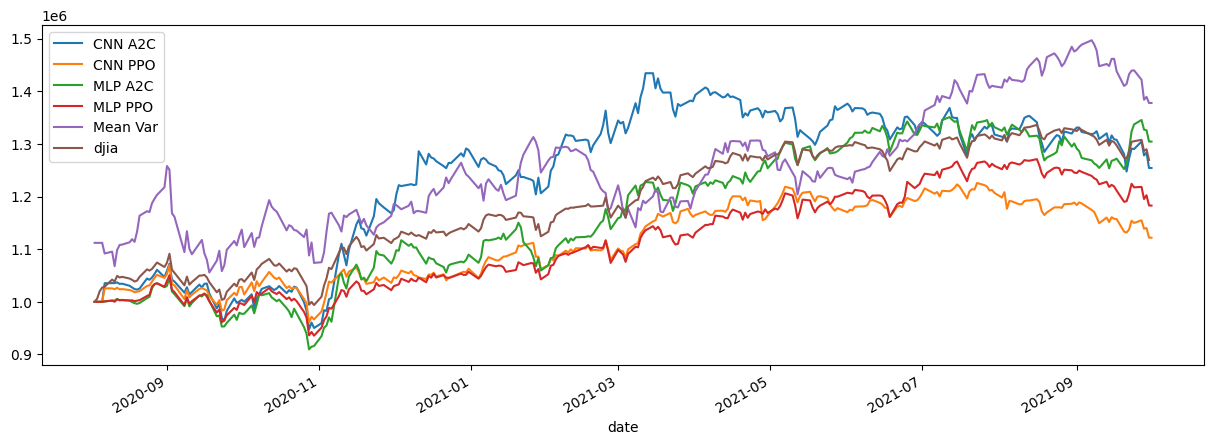

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()

<Axes: >

<Figure size 1500x500 with 0 Axes>

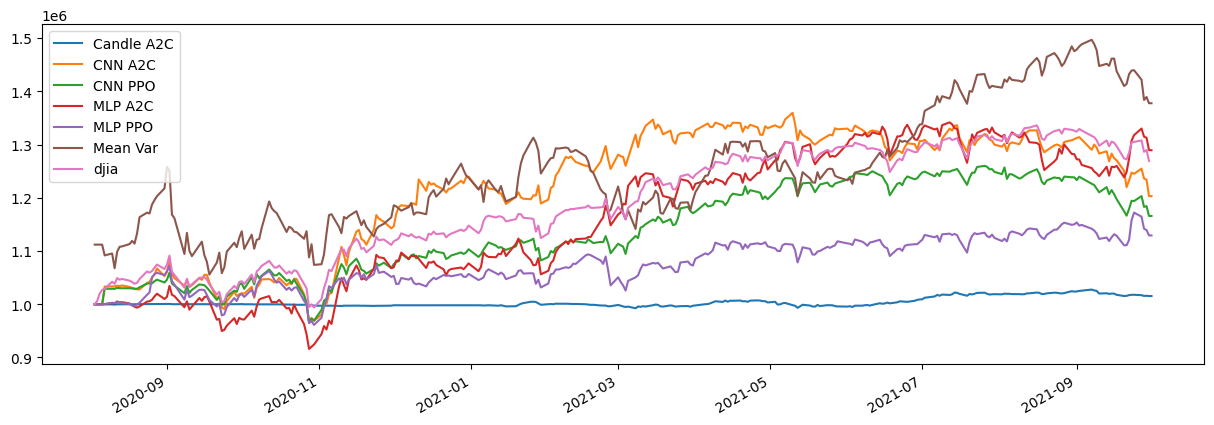

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()